<a href="https://colab.research.google.com/github/ssmith46/ship_Identification_CNN/blob/main/Ship_Identification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Title - Ship Recognition With Deep Learning<br>
Authors - Marina Davies & Sullivan Smith<br>
November 7 2024***

**Abstract** <br>

The goal of this project is to create a Deep Learning Model that can distinguish images that contain ships in them from images that do not. To do this, two different models will be created. The first model will be a standard Convolutional Neural Network created from scratch, and the second one will leverage the already trained VGG16 Convolutional Base Model. Both models will be trained using data augmentation, and their accuracies will be compared after both models have been trained, in order to determine which model can classify the images with higher accuracy.

The libraries that will be used in this project are given below.

In [ ]:
#The library imports for this project
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from google.colab import files
import os, shutil, pathlib
import numpy as np
import matplotlib.pyplot as plt
import random

print("Imports complete.")

Imports complete.


A function that will be used to plot the accuracy/loss of a model over both training and validation data, given it's history object obtained from the training process is given below.

In [ ]:
#Given a history object, plot the accuracy of train/val
def graphHistory(history):
  #Get the accuracy for training and validation data
  acc = history.history['accuracy']
  val_acc = history.history["val_accuracy"]
  #Get the loss for training and validation data
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  #Calculate the number of epochs the model was trained for
  epochs = range(1, len(acc) + 1)

  #Clear the figure
  plt.clf()

  #Plot the accuracy for training and validation performance
  #labeling them in the process
  plt.plot(epochs, acc, "bo", label="Training accuracy")
  plt.plot(epochs, val_acc, "b", label="Validation accuracy")

  #Title the plot
  plt.title("Training and validation accuracy")
  #Display the legend of the plot
  plt.legend()
  plt.figure()
  #Show the plot
  plt.show()

  print()
  #Clear the figure
  plt.clf()

  #Plot the loss for training and validation performance
  #labeling them in the process
  plt.plot(epochs, loss, "bo", label="Training loss")
  plt.plot(epochs, val_loss, "b", label="Validation loss")

  #Title the plot
  plt.title("Training and Validation loss")

  #Display the legend and show the plot
  plt.legend()
  plt.show()

print("graphHistory() defined.")

graphHistory() defined.


# **Data Preparation**

**I - Data Ingestion** <br>
<i>This section discusses the data source.</i> <br>
The data source for this project is a Kaggle notebook {1} with images of ships, as well as various large landscape elements (e.g. buildings, ports, water). There are a total of 4000 images in this set, each an 80x80 RGB image. Each image has a coresponding label 0, or 1 that dictates whether there is a ship in the image, or not, respectively. In this dataset, there are 1000 images labeled as having ships, and 3000 labeled no-ship.

The first thing that needs to be done in order to import the dataset from Kaggle is to link Google Colab and Kaggle credentials. This is done in the below code.

In [ ]:
#Uploading kaggle token to notebook
files.upload()
#Create the directory to store credentials
!mkdir ~/.kaggle
#Copy the kaggle credentials to the kaggle directory
!cp kaggle.json ~/.kaggle/
#Change the permissions of this file
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle account linked.")

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
Kaggle account linked.


Once successful linking of accounts is complete, the dataset can be downloaded with the following code. This imports the dataset as a .zip file.

In [ ]:
#Data Ingestion Code Goes Here
!kaggle datasets download -d rhammell/ships-in-satellite-imagery

print("Kaggle dataset downloaded.")

Dataset URL: https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery
License(s): CC-BY-SA-4.0
ships-in-satellite-imagery.zip: Skipping, found more recently modified local copy (use --force to force download)
Kaggle dataset downloaded.


Now that the dataset has been imported as a .zip file, it must be unzipped to have access to the actual images within the dataset. The code below does this.

In [ ]:
#Unzip the dataset
!unzip -qq ships-in-satellite-imagery.zip

print("Dataset unzipped.")

replace scenes/scenes/lb_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Dataset unzipped.


**II - Data Cleaning/Normalization** <br>
<i>This section discusses how the data was cleaned and/or normalized.</i> <br>

Before the images can be normalized, they must first be divided into their relative subdirectories ("ship" and "no-ship") as currently they are just in one large directory. This section contains the code that goes over how this is done. <br>

Once the images are divided into their relative 'ship' 'no-ship' subdirectories, the images can be normalized. The first thing to do to normalize the images is to get the RGB pixel values to be a value between [0-1] rather than [0-255]. This can be done by simply dividing each pixel value by 255. Next, the values of the image will need to be transformed into float data type, that way the model can manipulate the data easier. To achieve this normalization, a rescaling layer will be added at the beginning of the model that rescales the images to a normalized value. The code for this layer is given below.

In [ ]:
#Create a layer that will be used to normalize the images during training
rescalingLayer = layers.Rescaling(1./255)

print("Rescaling layer created.")

Rescaling layer created.


At this point, the data is organized in the below file structure:

shipsnet/<br>
<blockquote>
  shipsnet/<br>
  <blockquote>
    img1 <br>
    img2 <br>
    ... <br>
  </blockquote>
</blockquote>

It is important to note that the class label of each image ("ship" or "no-ship") is embedded into the name of the image as either a '0' or '1'. The below code parses the name of each image in order to move it to a 'sorted_images_dir' with both 'ship' and 'no-ship' subdirectories. Each of these subdirectories will contain all the images with and without ships (respectively).

In [ ]:
#Defining the original and new locations of images
original_dir = pathlib.Path("shipsnet/shipsnet")
new_base_dir = pathlib.Path("sorted_images_dir")

print("Original and new_base directories created.")

Original and new_base directories created.


In [ ]:
#Define the different class names and map them to a dictionary
class_names = ["no-ship", "ship"]
class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

print("Class names mapped to [0,1] labels.")

Class names mapped to [0,1] labels.


This function loads the images from the original directory into the new sorted images directory as explained above. The concept for this idea was taken from source {3} in the below mentioned sources.

In [ ]:
#Sorts the images into two directories, one for ships, other for no ships
def load_data_into_label_directories(dataset_name):

  #Grab a picture from the dataset directory
  for picture in os.listdir(dataset_name):

    #Gets the label for this image out of the name
    class_name = picture.split("__")[0]

    #Figure out the label in terms of "ship" "no-ship" given number '0' or '1'
    for key, value in class_name_labels.items():
      if value == int(class_name):
        label = key

    #Figure out directory going to put image in based on label
    dir = new_base_dir / label
    #Create this directory only if it doesn't exist
    if (os.path.isdir(dir)):
      pass
    else:
      os.makedirs(dir)

    #Figure out what the path to the image exactly is
    img_path = os.path.join(dataset_name, picture)

    #Copy the image to the new destination directory
    shutil.copyfile(src=original_dir / picture,
                    dst=dir / picture)

print("load_data_into_label_directories() defined.")

load_data_into_label_directories() defined.


In [ ]:
#Load the images into the "ship" "no-ship" directories using the above function
load_data_into_label_directories("shipsnet/shipsnet")

#Output the number of images in the ship directory
print("Ships:", len([f for f in os.listdir("sorted_images_dir/ship")]))
#Output the number of images in the no-ship directory
print("No-ships:", len([f for f in os.listdir("sorted_images_dir/no-ship")]))

print("Images moved to labeled directories.")

Ships: 1000
No-ships: 3000
Images moved to labeled directories.


**III - Preparation of Training, Validation and Test Sets** <br>
<i>This section discusses how the training, validation, and test sets were created. What was your strategy? Did you use k-fold validation?</i>
<br>
Here, the data cleaned in the previous step will need to be split into training, testing, and validation data. Since there are 1000 images with ships, and 3000 without, the data should be split such that the model has enough of either class to digest the data, and not overfit to one particular class. Thus, 500 images of ships will be used in the training data, 200 will be used for validation, and 300 will be held out for testing data. For the 'no-ship' class, 1500 images will be used in the training data, 600 will be used for validation, and 900 will be used in the test data. The validation data will be used to validate the model's performance after each epoch in the training process, by passing it to the model at the time of training.
<br>

Now that the images are divided into ship and no-ship subdirectories, it is time to properly divide the images into training, validation, and testing subsets. This section contains the code that goes over how to achieve this.

In [ ]:
#Change the directory locations of original and base directories
original_dir = new_base_dir
new_base_dir = pathlib.Path("project_datasets")

print("Directory locations swapped.")

Directory locations swapped.


This function moves images from the original directory to a new project_datasets directory where the subsetted images are divided into training, validation, and testing subsets.

In [ ]:
#Create a subset of images using the name and numbers passed
def make_subset(subset_name, num_ships, num_no_ships):

  #Take samples from both "ship" and "no-ship" directories
  for category in ("ship","no-ship"):

    #Craft the location that the image will be moved to
    dir = new_base_dir / subset_name / category

    #Create this directory only if it doesn't exist
    if (os.path.isdir(dir)):
      pass
    else:
      os.makedirs(dir)

    #Figure out all the files in the directory based on category
    files = os.listdir(original_dir / category)

    #Randomly shuffle all the files to take a random sample
    #This random number generator is seeded for reproductive purposes
    random.Random(1337).shuffle(files)

    #Caclculate the number of images moving based on category and
    #number provided as an argument
    num_moving = num_no_ships
    if (category == "ship"):
      num_moving = num_ships

    #Get the subset of the images going to move via python slicing
    moving = files[-num_moving:]

    #Need to save some images for the "complete_dataset" when retraining
    #so need to store images in the train and validation directories here
    #also. This code copies the images over to this directory
    if (subset_name in ("train", "validation")):
      #The "complete_dataset" directory location
      complete_dir = new_base_dir / "complete_dataset" / category
      #Create only if it doesn't exist
      if (os.path.isdir(complete_dir)):
        pass
      else:
        os.makedirs(complete_dir)

      #Copy all the images over here
      for fname in moving:
        shutil.copy(original_dir / category / fname,
                    complete_dir / fname)

    #Actually move the images from the original directory to the
    #new subset directory
    for fname in moving:
      shutil.move(original_dir / category / fname,
                  dir / fname)

print("make_subset() defined.")


make_subset() defined.


Using the above function, the images are divided into their relative subsets using the below code.

In [ ]:
#Calculate the total number of ships and no-ships images
ships = len([f for f in os.listdir("sorted_images_dir/ship")])
no_ships = len([f for f in os.listdir("sorted_images_dir/no-ship")])

#These are the data splits for training, validation, and testing data
train_perc = .5
val_perc = .2
test_perc = .3

print("The datasets are divided as follows:")
print()
#Create the training subset and output the number of each class
make_subset("train", int(train_perc*ships), int(train_perc*no_ships))
print("Train (ships):", len([f for f in os.listdir("project_datasets/train/ship")]))
print("Train (no-ships):", len([f for f in os.listdir("project_datasets/train/no-ship")]))
print()
#Create the validation subset and output the number of each class
make_subset("validation", int(val_perc*ships), int(val_perc*no_ships))
print("Validation (ships):", len([f for f in os.listdir("project_datasets/validation/ship")]))
print("Validation (no-ships):", len([f for f in os.listdir("project_datasets/validation/no-ship")]))
print()
#The final training dataset should now be complete, output the numbers here
print("Final Training Dataset (for retraining) (ships):", len([f for f in os.listdir("project_datasets/complete_dataset/ship")]))
print("Final Training Dataset (for retraining) (no-ships):", len([f for f in os.listdir("project_datasets/complete_dataset/no-ship")]))
print()
#Create the testing subset and output the number of each class
make_subset("test", int(test_perc*ships), int(test_perc*no_ships))
print("Test (ships):", len([f for f in os.listdir("project_datasets/test/ship")]))
print("Test (no-ships):", len([f for f in os.listdir("project_datasets/test/no-ship")]))
print()
print("Data divided.")


The datasets are divided as follows:

Train (ships): 500
Train (no-ships): 1500

Validation (ships): 200
Validation (no-ships): 600

Final Training Dataset (for retraining) (ships): 700
Final Training Dataset (for retraining) (no-ships): 2100

Test (ships): 300
Test (no-ships): 900

Data divided.


Now that the images are divided into their relative subset directories, we can create dataset objects using the file paths. Dataset objects have higher performance rates during the training process of the model when compared to pulling each image from the file path each time. Thus, dataset objects are created for each of the subsets created above.

In [ ]:
#Now that the data is divided, dataset objects can be created
#for quicker training process

#Create the training dataset object
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(80,80),
    batch_size=32
)
#Create the validation dataset object
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(80,80),
    batch_size=32
)
#Create the complete dataset object
complete_dataset = image_dataset_from_directory(
    new_base_dir / "complete_dataset",
    image_size=(80,80),
    batch_size=32
)
#Create the testing dataset object
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(80,80),
    batch_size=32
)

print("Datasets created.")

Found 2000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 2800 files belonging to 2 classes.
Found 1200 files belonging to 2 classes.
Datasets created.


# **Data Exploration**

Before beginning the creation of models, it is important to take a look at what exactly the input data will look like. For this project, the input type will be images. A few of the images that will be used in the training set are given below.

Images shown.


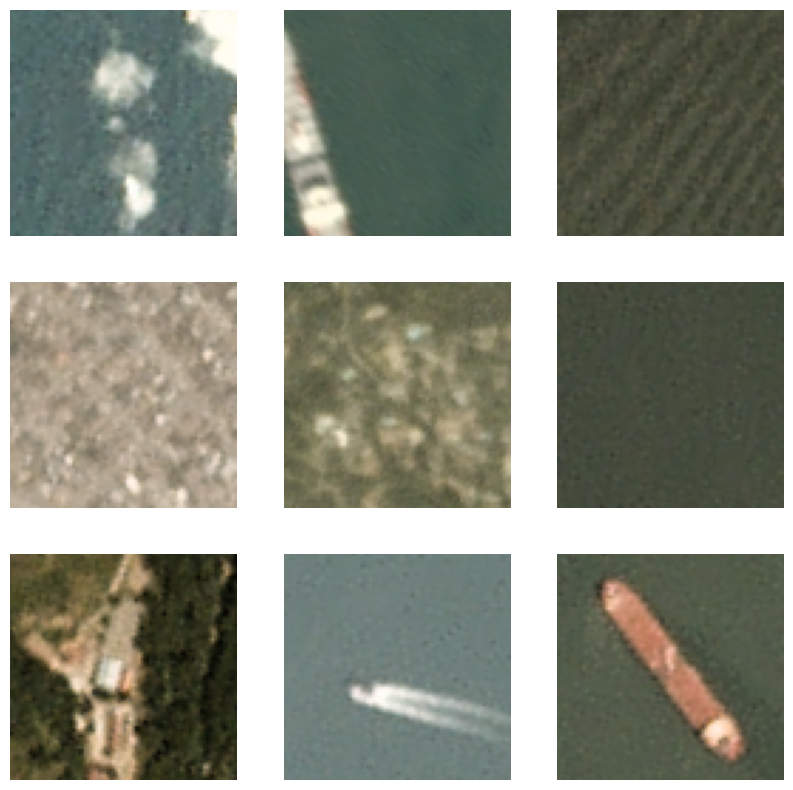

In [ ]:
#Visualizes some of the images from the training set

#Create a plot for 9 images
plt.figure(figsize=(10,10))

#Iterate over training set 9 times
for i in range(9):
  #Go ahead and grab an image from the dataset
  for images, _ in train_dataset.take(i+1):
    #Plot it onto the figure
    ax = plt.subplot(3,3,i+1)
    #Show the image on the plot
    plt.imshow(images[0].numpy().astype("uint8"))
    #Turn off the axis indicators
    plt.axis("off")

print("Images shown.")

The shapes of these input images can also be explored. The code to do this is given below.

In [ ]:
#View the shape of one data and label batch
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

print("Shapes of dataset labels and data shown.")

data batch shape: (32, 80, 80, 3)
labels batch shape: (32,)
Shapes of dataset labels and data shown.


# **Data Augmentation**

When creating deep learning models that will process and classify images, an important step to include in the training process is data augmentation. This augmentation allows the model to train for more epochs before it begins overfitting. To do this, a data augmentation layer is created below, and will be used in both models for this project.

In [ ]:
#Create an image augmentation layer that can go at the
#beginning of our models during the training process
data_augmentation = keras.Sequential(
    [
        #Randomly flip the image horizontally
        layers.RandomFlip("horizontal"),
        #Randomly rotate the image
        layers.RandomRotation(0.1),
        #Randomly zoom in/out the image
        layers.RandomZoom(0.2),
    ]
)

print("Data augmentation layer created.")

Data augmentation layer created.


In order to get a feel for how the data augmentation layer works, the below code will augment and plot an image from the training set.

Augmented image shown.


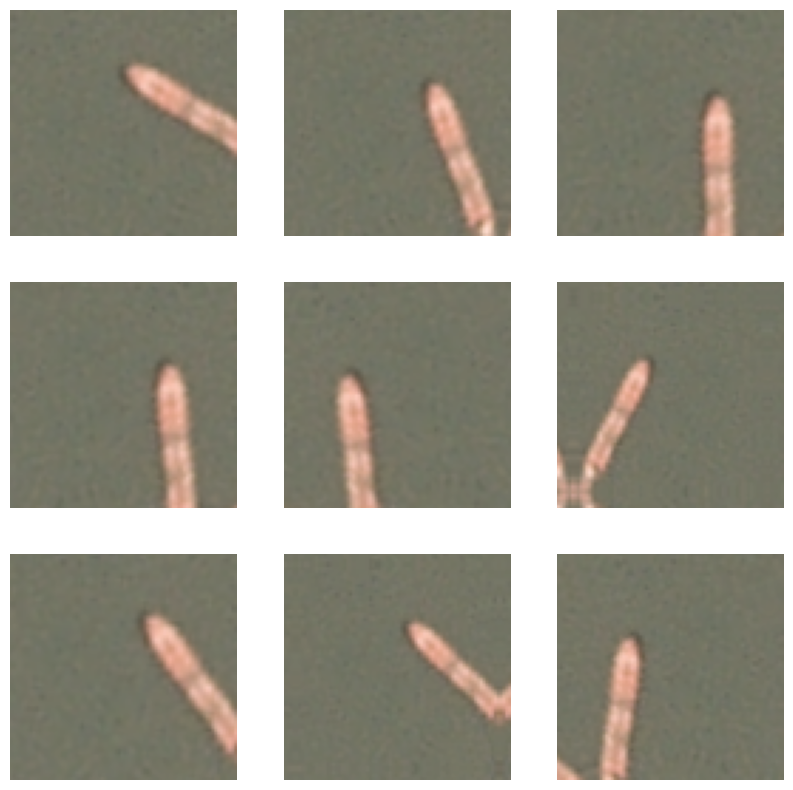

In [ ]:
#Visualizes one of the images from the training dataset
#as it passes through the augmentation layer several times

#Create a plot for displaying 9 images
plt.figure(figsize=(10,10))

#Get an image from the training dataset
for images, _ in train_dataset.take(1):

  #Augment the image 9 times
  for i in range(9):
    #Get the image after augmentation
    augmented_images = data_augmentation(images)
    #Figure out position on the plot
    ax = plt.subplot(3,3,i+1)
    #Show the image on the plot
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    #Turn off the axis marks on the plot
    plt.axis("off")

print("Augmented image shown.")

At this point in the project, the data is loaded into three dataset object, each with proportional ratios. Normalization during the training process has been discussed, and the augmentation layer has been described. We are now ready to begin training and testing our models.

# **Convolutional Neural Network from Scratch (Marina)**

**A - Construction of the Deep Learning Model (From Scratch)** <br>
<i>This section discusses how the various parameters were chosen for your model.</i>

Since we are trying to predict if a ship is or is not present in the image we will be using a sigmoid activation function with a single node at the end of the model, if it returns a value of over .5 then we predict that a ship is present and other wise we predict that there is not a ship present. Since this is a binary classification problem and our final output is a probablility the loss function will be "binary_crossentropy" and the metric will be accuracy. The optimizer we will use is rmsprop.

In [ ]:
#Will return MarinaModel1 architecture as well as a callback
def MarinaModel1(cbpf: str):

  #Input layer with the correct size for the images
  inputs = keras.Input(shape=(80, 80, 3))
  #Messing with the pictures to fight overfitting
  x = data_augmentation(inputs)
  #Rescales the images to 0-1
  x = rescalingLayer(x)

  #All of this fun jazz with layers just learning the data
  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
  #Flattening so we can go to a dense layer
  x = layers.Flatten()(x)

  #dropout to fight overfitting
  x = layers.Dropout(0.5)(x)
  #Dense layer to output a probability
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)

  #compiles the model with the appropriate loss, optimizer, and metrics
  model.compile(loss="binary_crossentropy",
  optimizer="rmsprop",
  metrics=["accuracy"])

  #creates a callback
  callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath=f"{cbpf}.keras",
      verbose = 1,
      save_best_only=True,
      monitor="val_loss"
      )
    ]

  return model, callbacks

print("MarinaModel1() defined.")

MarinaModel1() defined.


In [ ]:
#Will return MarinaModel2 architecture as well as a callback
#MarinaModel2 has one less MaxPooling2D and Conv2D layers to see if the images are small enough to not need another
def MarinaModel2(cbpf: str):

  #Input layer with the correct size for the images
  inputs = keras.Input(shape=(80, 80, 3))
  #Messing with the pictures to fight overfitting
  x = data_augmentation(inputs)
  #Rescales the images to 0-1
  x = rescalingLayer(x)

  #All of this fun jazz with layers just learning the data
  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
  #Flattening so we can go to a dense layer
  x = layers.Flatten()(x)

  #dropout to fight overfitting
  x = layers.Dropout(0.5)(x)
  #Dense layer to output a probability
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)

  #compiles the model with the appropriate loss, optimizer, and metrics
  model.compile(loss="binary_crossentropy",
  optimizer="rmsprop",
  metrics=["accuracy"])

  #creates a callback
  callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath=f"{cbpf}.keras",
      verbose = 1,
      save_best_only=True,
      monitor="val_loss"
      )
    ]

  return model, callbacks

print("MarinaModel2() defined.")

MarinaModel2() defined.


In [ ]:
#Actually getting the models and callbacks
MarinaModel11, MarinaCallbacks11 = MarinaModel1("MMCB1")

MarinaModel22, MarinaCallbacks22 = MarinaModel2("MMCB2")

**B - Training of the Model** <br>
We will train the model on the data after being put through the augmenting image generator so as to slow/prevent overfitting. We will run it for 100 epochs to see when it starts to overfit and then we'll stop it there. Using validation data to see when overfitting begins and a callback to save the best performing version of the model.

In [ ]:
#Fitting the MarinaModel1 architecture on the training dataset with validation data
MarinaHistory1 = MarinaModel11.fit(
  train_dataset,
  epochs=100,
  validation_data=validation_dataset,
  callbacks=MarinaCallbacks11)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7266 - loss: 0.6045
Epoch 1: val_loss improved from inf to 0.40160, saving model to MMCB1.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.7270 - loss: 0.6039 - val_accuracy: 0.8313 - val_loss: 0.4016
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8054 - loss: 0.4349
Epoch 2: val_loss improved from 0.40160 to 0.30204, saving model to MMCB1.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8058 - loss: 0.4343 - val_accuracy: 0.8562 - val_loss: 0.3020
Epoch 3/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8529 - loss: 0.3604
Epoch 3: val_loss improved from 0.30204 to 0.20263, saving model to MMCB1.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8534 - loss: 0.3587 - val_accuracy: 0.9162 - val_loss: 0.2026
Epoch 4/100
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8818 - loss: 0.2811
Epoch 4: val_loss did not improve from 0.20263
63/63 ━━━━━━━━━━━━━━━━━━

In [ ]:
#Fitting the MarinaModel2 architecture on the training dataset with validation data
MarinaHistory2 = MarinaModel22.fit(
  train_dataset,
  epochs=100,
  validation_data=validation_dataset,
  callbacks=MarinaCallbacks22)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7442 - loss: 0.5822
Epoch 1: val_loss improved from inf to 0.69249, saving model to MMCB2.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7449 - loss: 0.5808 - val_accuracy: 0.7538 - val_loss: 0.6925
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8364 - loss: 0.3851
Epoch 2: val_loss improved from 0.69249 to 0.25003, saving model to MMCB2.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8367 - loss: 0.3843 - val_accuracy: 0.9075 - val_loss: 0.2500
Epoch 3/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8783 - loss: 0.2899
Epoch 3: val_loss did not improve from 0.25003
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8780 - loss: 0.2898 - val_accuracy: 0.8575 - val_loss: 0.3564
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8914 - loss: 0.2503
Epoch 4: val_loss improved from 0.25003 to 0.19722, saving model to MMCB2.keras
63/63 ━━━━━━━━━━━━━━━━━━━

Comparing how each architecture did to see which one should be used to train the final model

In [ ]:
test_model1 = keras.models.load_model("MMCB1.keras")
test_loss1, test_acc1 = test_model1.evaluate(test_dataset)


test_model2 = keras.models.load_model("MMCB2.keras")
test_loss2, test_acc2 = test_model2.evaluate(test_dataset)


print(f"Test accuracy 1: {test_acc1:.3f}, Test Loss 1: {test_loss1:.3f}")
print(f"Test accuracy 2: {test_acc2:.3f}, Test Loss 2: {test_loss2:.3f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9951 - loss: 0.0324
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9947 - loss: 0.0154
Test accuracy 1: 0.994, Test Loss 1: 0.038
Test accuracy 2: 0.992, Test Loss 2: 0.025


**C - Visualization of Training Effectiveness** <br>
<i>This section visualizes the training results.</i>


Plotting the history of the training validation data's loss for the two models with the y axis being loss/accuracy and the x axis being the epochs. It skips the first 10 epochs so they don't mess up the graphs' scale.

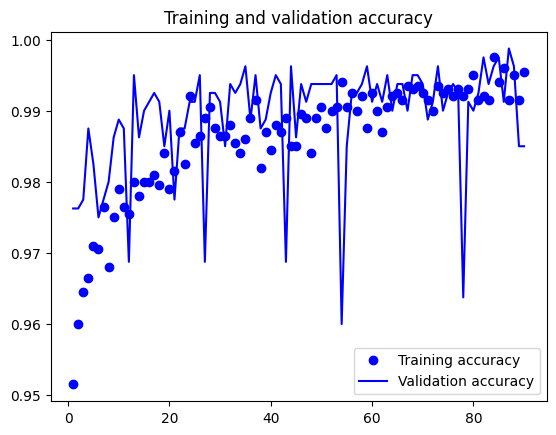

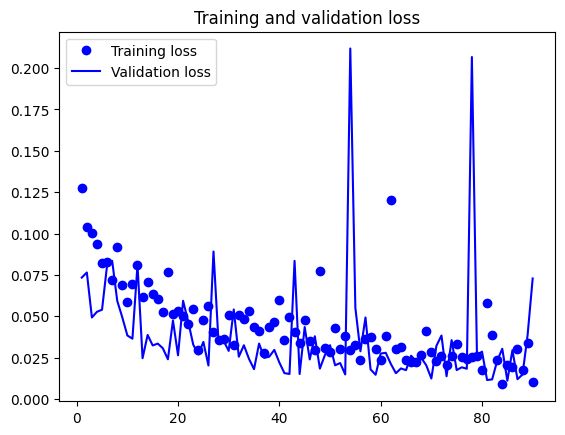

In [ ]:
#Model Visualization Of the MarinaModel1 Architecture
accuracy = MarinaHistory1.history["accuracy"][10:]
val_accuracy = MarinaHistory1.history["val_accuracy"][10:]
loss = MarinaHistory1.history["loss"][10:]
val_loss = MarinaHistory1.history["val_loss"][10:]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

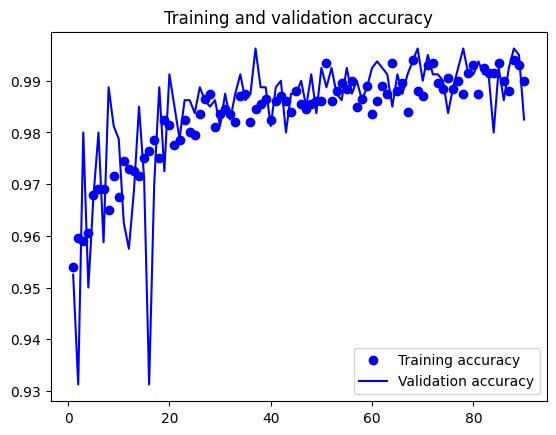

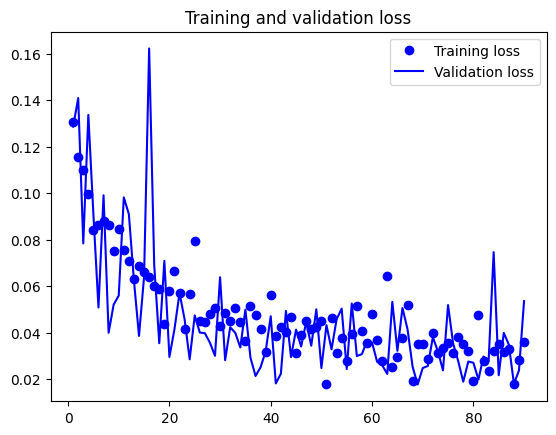

In [ ]:
#Model Visualization Of the MarinaModel2 Architecture
accuracy = MarinaHistory2.history["accuracy"][10:]
val_accuracy = MarinaHistory2.history["val_accuracy"][10:]
loss = MarinaHistory2.history["loss"][10:]
val_loss = MarinaHistory2.history["val_loss"][10:]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**D - Getting the Final model with the appropriate architecture** <br>
<i>This section discusses the making of the final model based on best performing architecture.</i>

In [ ]:
#Getting the Final model with the MarinaModel2 architecture
MarinaModelFinal, MarinaCallbacksFinal = MarinaModel2("MMCBFinal")

**E - Final Training of the Model Using the Complete Training Dataset** <br>

In [ ]:
#Fitting the final model on the complete dataset
MarinaHistoryFinal = MarinaModelFinal.fit(
  complete_dataset,
  epochs=75,
  )

Epoch 1/75
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7300 - loss: 0.5930
Epoch 2/75
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8615 - loss: 0.3252
Epoch 3/75
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8846 - loss: 0.3054
Epoch 4/75
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9018 - loss: 0.2340
Epoch 5/75
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9149 - loss: 0.2118
Epoch 6/75
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9288 - loss: 0.1837
Epoch 7/75
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9429 - loss: 0.1556
Epoch 8/75
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9440 - loss: 0.1385
Epoch 9/75
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9492 - loss: 0.1370
Epoch 10/75
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9579 - loss: 0.1099
Epoch 11/75
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9626 - loss: 0.1054
Epoch 12/75
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy:

**F - Final Testing of the Model Based on the Test Data**

In [ ]:
#Testing the final model on the test dataset
MarinaFinalTestLoss, MarinaFinalTestAccuracy = MarinaModelFinal.evaluate(test_dataset)
print(f"Final Test Accuracy: {MarinaFinalTestAccuracy:.3f}, Final Test Loss: {MarinaFinalTestLoss:.3f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9887 - loss: 0.0333
Final Test Accuracy: 0.990, Final Test Loss: 0.039


# **VGG16 Convolutional Base Model (Sullivan)**

**A - Construction of the Deep Learning Model (VGG16)** <br>
<i>This section discusses how the training, validation, and test sets were created. What was your strategy? Did you use k-fold validation?</i>
<br>
For this model, the VGG16 Convolutional Base Model will be leveraged in order to compare it's performance to a model that was specially trained on the ship/no-ship data itself. Similar to the previous CNN built from scratch, this model will have a single output node with a sigmoid activation function, in order to guage the model's predicition between [0-1] in terms of the corresponding labels ship/no-ship. The loss for this model will be "binary_crossentropy", and the metric that will be monitored will be accuracy.
<br>
This model will have several layers used to find and disect important components from the original image. To do this, Conv2D, and Maxpooling layers will disect the image, and a Dense network will predict the presence of a ship at the end of the model. The Conv2D and Maxpooling layers will mainly come from the VGG16 base, but a few may be re-trained in the later layers to more fit with the specific task at hand.

The code below imports the VGG16 base model that will be used in a new CNN model. The last 4 layers of the VGG16 base will be unfrozen in order to fine-tune them to work well with the specific task of identifying ships within images, while the other layers in the base will remain frozen. This is to help prevent overwriting all the work that the company that trained this model put in when the base was created.

In [ ]:
#Get the convoultional base VGG16 model
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet", #weight checkpoint to initialize model
    include_top=False, #Don't include the densly connected classifier
    input_shape=(80,80,3) #The shape of the imput images
)

#Unfreeze the weights in order to see how many trainable weights there are
conv_base.trainable = True
print("The number of trainable weights before freezing is:",
      len(conv_base.trainable_weights))

#See a summary of the conv_base taking from VGG16
conv_base.summary()

#Freeze all the layers up to the last 4 layers
#These will be left unfrozen in order to re-train them for our specific model
for layer in conv_base.layers[:-4]:
  layer.trainable = False

#Now that the base has been mostly frozen, re-check how many trainable weights there are
print("The number of trainable weights after freezing some is:",
      len(conv_base.trainable_weights))

print("VGG16 base imported and frozen.")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
The number of trainable weights before freezing is: 26


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 80, 80, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 80, 80, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 80, 80, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 40, 40, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 40, 40, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 40, 40, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 20, 20, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 20, 20, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 20, 20, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 10, 10, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 10, 10, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 10, 10, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 5, 5, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 5, 5, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 5, 5, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

The number of trainable weights after freezing some is: 6
VGG16 base imported and frozen.


To save the best performing model that is achieved during the training process, callbacks will be used that monitor the loss over the validation dataset. By using these callbacks, the best model can be retrieved later on, even if it begins to overfit. The code to create this callback is given below.

In [ ]:
#The callbacks this model will use during the training process is given here.
#This will save the model that reaches the lowest loss over the validation data
#during the training of the model.
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath = "feature_extraction_with_data_augmentation_fine_tuning.keras",
    save_best_only=True,
    monitor="val_loss"
)]

print("Callbacks for model defined.")

Callbacks for model defined.


In [ ]:
#This function will return a fully compiled model with the tuned VGG16 base model layers
def getATunedModel():
  #Create an input layer that will take the images in as input
  inputs = keras.Input(shape=(80, 80, 3))
  #The data augmentation layer
  x = data_augmentation(inputs)
  #The data normalization layer
  x = rescalingLayer(x)
  #The VGG16 pre-process layer
  x = keras.applications.vgg16.preprocess_input(x)
  #The mostly frozen VGG16 base layers
  x = conv_base(x)
  #A flatten layer before passing to a MLP
  x = layers.Flatten()(x)
  #A dense layer with 256 nodes in it
  x = layers.Dense(256)(x)
  #A dropout layer to help with overfitting
  x = layers.Dropout(0.5)(x)
  #A single output node with sigmoid activation, in order to calculate
  #probability between 0 and 1 of the image containing a ship
  outputs = layers.Dense(1, activation="sigmoid")(x)

  #Create the model with all the above defined layers
  model = keras.Model(inputs, outputs)

  #Compile the now created model
  model.compile(loss="binary_crossentropy", #two class classification problem
                #The learning rate is very low here to limit the retraining of the final layers in the VGG16 base
                optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), #how the model will move towards higher accuracy
                metrics=["accuracy"] #will measure the accuracy of the model
                )

  return model

print("getATunedModel() defined.")

getATunedModel() defined.


**B - Training of the Model** <br>
Now that the function to create the model has been created, the model is ready for training. Since callbacks are being used, the model will just be trained for a lot of epochs in order to ensure it overfits the training data. The best performing model will be saved off and can be retrieved afterwards. To ensure that the model is overfitting the training data, the history plot of the training and validation accuracies and losses will be analyzed, after training.

In [ ]:
#Model Training Code Goes Here

#Get a tuned model using the above function
model = getATunedModel()

#Display a summary of the model's architecture
model.summary()

#Do the actual training of the model
vgg16_history = model.fit(
    #Train the model with the training set
    train_dataset,
    #Will train for 75 epochs
    epochs=75,
    #Use the validation data as validation
    validation_data = validation_dataset,
    #Use callbacks in order to retreive the best model from training for test data
    callbacks=callbacks
)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 80, 80, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 80, 80, 3)      │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 80, 80, 3)      │              0 │ sequential[3][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 80, 80)         │              0 │ rescaling[3][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 80, 80)         │              0 │ rescaling[3][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 80, 80)         │              0 │ rescaling[3][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 80, 80, 3)      │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 80, 80, 3)      │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 2, 2, 512)      │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 2048)           │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        524,544 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 256)            │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │            257 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 15,239,489 (58.13 MB)

 Trainable params: 7,604,225 (29.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/75
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.5120 - loss: 2.0480 - val_accuracy: 0.7500 - val_loss: 0.5527
Epoch 2/75
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.6657 - loss: 0.7576 - val_accuracy: 0.7500 - val_loss: 0.5521
Epoch 3/75
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.7381 - loss: 0.5920 - val_accuracy: 0.7500 - val_loss: 0.6312
Epoch 4/75
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.7476 - loss: 0.5745 - val_accuracy: 0.7500 - val_loss: 0.5650
Epoch 5/75
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7436 - loss: 0.5811 - val_accuracy: 0.7500 - val_loss: 0.5552
Epoch 6/75
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.7516 - loss: 0.5721 - val_accuracy: 0.7500 - val_loss: 0.5625
Epoch 7/75
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.7559 - loss: 0.5657 - val_accuracy: 0.7500 - val_loss: 0.5530
Epoch 8/75
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7565 - loss: 0.5561 - val_accuracy: 0.7500 - 

**C - Visualization of Training Effectiveness** <br>
<i>This section visualizes the training results.</i> <br>
Using the history object generated by the model during the training of the model, the test/validation accuracy/loss is shown here.

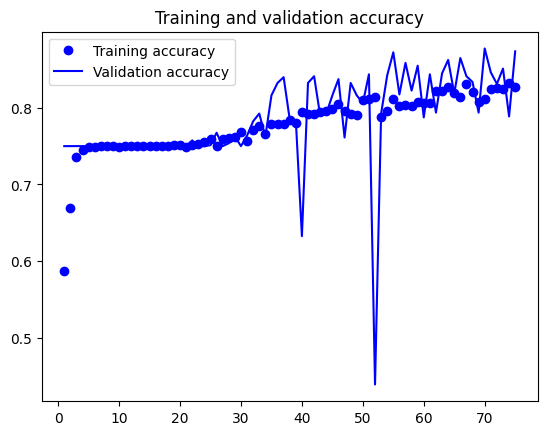

<Figure size 640x480 with 0 Axes>

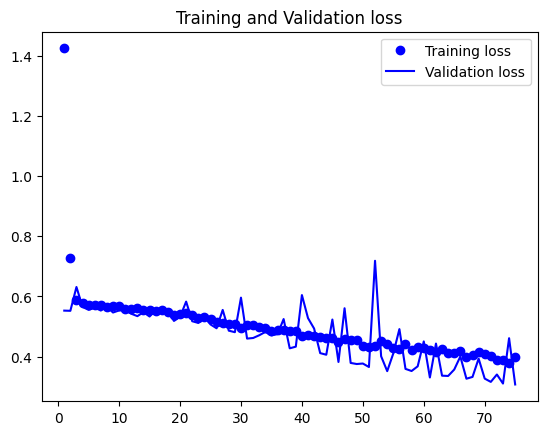

Model history graphed.


In [ ]:
#Use the previously defined function to graph the model's accuracy over the 75 epochs
graphHistory(vgg16_history)
print("Model history graphed.")

Given the above plot, it appears that the model began overfitting the training data around 70ish epochs. This means when we use the callbacks in the below code to retrieve the saved model, the returned model is probably being pulled from around 70 epochs.

**D - Final Testing of the Model Based on the Test Data**

In [ ]:
#Model Final Testing Code Goes Here
#Retrieve the model with the best validation performance using callbacks
model = keras.models.load_model("feature_extraction_with_data_augmentation_fine_tuning.keras")
#Using the retrieved model, evaluate it over the test set
test_loss, test_acc = model.evaluate(test_dataset)
#Display the accuracy of the model over the test set
print(f"Final Test Accuracy: {test_acc:.3f} Final TestLoss: {test_loss:.3f}")

print("Model trained and evaluated over test data.")

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8626 - loss: 0.3146
Final Test Accuracy: 0.863 Final TestLoss: 0.313
Model trained and evaluated over test data.


# **Comparisons**

**IV - Visualizing and Comparing the Accuracy of Both Models** <br>
Here, the accuracies of both models over the test data will be compare to determine which one performed better.

In [ ]:
#Code used to display model accuracies goes here
print(f"Convolutional Neural Network Test Accuracy: {MarinaFinalTestAccuracy:.3f}, Convolutional Neural Network Test Loss: {MarinaFinalTestLoss:.3f}")
print(f"VGG16 Convolutional Base Model Test Accuracy: {test_acc:.3f}, VGG16 Convolutional Base Model Loss Accuracy: {test_loss:.3f}")

Convolutional Neural Network Test Accuracy: 0.990, Convolutional Neural Network Test Loss: 0.039
VGG16 Convolutional Base Model Test Accuracy: 0.863, VGG16 Convolutional Base Model Loss Accuracy: 0.313


**V - Analysis of the Accuracies of Either Model**
<br>
A brief analysis on which model performs better will be given here.

The Convolutional Neural Network performed better than the VGG16 Convolutional Base Model on this problem. It has four Conv2D layers and three MaxPooling2D layers, one in between each of the Conv2D layers. The model architecture was chosen by comparing it to one with five and four Conv2D layers and MaxPooling2D layers respective in the initial training stage to see which one performed better. To compare the two we used "keras.callbacks.ModelCheckpoint" to check which model performed better with the version of each model before they began to overfit.

The reason we used four layers instead of five was to ensure that the model did not overfit too quickly and to try to find a happy middle ground between learning relations too quickly and not being able to learn complex enough relations. It uses a kernal size of 3 meaning that it looks at 3 by 3 windows at a time to learn local patterns and relationships. It uses MaxPooling2D layers with a poolsize of 2 to downsize the data by roughly half. It then flattens the data and goes into a dense layer with sigmoid activation to output a probability using binary crossentropy to determine if there is or isn't a ship in the given image.

# **Conclusion**

**VI - Conclusions** <br>
<i>Provide a brief paragraph discussion the lessons you learned in this project.</i> <br>
A concusion will be given here comparing the two models, and determining which did better.

The Convolutional Neural Network did better than the VGG16 Convolutional Base Model. It had both a higher accuracy and a lower loss than the VGG16. This is likely because the final version of the Convolutional Neural Network was trained on the complete dataset, both training and validation data, while the VGG16 Model was only trained on the training data and not the validation data. Another reason the from scratch model might've performed better is that this training data is all it knows while the pretrained model was not only trained to differentiate many many more different classes, but also was taught to distinguish different types of boats from each other.

One lesson we learned is that despite the portability and the reusability of a pretrained model trained on a much larger dataset, having a pretrained model does not necessarily mean that it will perform better on any given problem than a Convolutional Neural Network built from scratch. Another lesson we learned is that you can not really rerun your code a lot of times as Marina had to buy the Colab Pro subscription since she ran out of "compute units."

**VII - References** <br>
<i>Provide references that shaped the procedure discussed above</i>

<br>
{1} rhammell. (2018). Ships in Satellite Imagery. Kaggle.com. https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery
‌<br>
{2} Dufour, P. (2020, July 22). Training with Image Data Augmentation in Keras. Step up AI. https://stepup.ai/train_data_augmentation_keras/?fbclid=IwAR2_2Kvzfqw6xBIWOabDYEcN4nxH8xcX3G4IpSaALVgAesny2UEDqohn158
‌<br>
{3} sohampatil591. (2024, April 26). Faster_R-CNN_model. Kaggle.com; Kaggle. https://www.kaggle.com/code/sohampatil591/faster-r-cnn-model
‌<br>
{4} Chollet, F. (2018). Deep Learning with Python. Manning, Cop.
